In [36]:
import tensorflow as tf
import os
import numpy as np
import nibabel as nib
from nibabel.affines import apply_affine
import matplotlib.pyplot as plt
import scipy.interpolate as inter
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [37]:
#load image !!!
img = nib.load('img.nii.gz')

BLOCK_SIZE = 63

model = tf.keras.models.load_model('./models/Size_63_epoch_25_range_14_conv_3_regularized_dropout.keras')

#Get access to some kind of array
array_img = img.dataobj

#retrieve array of the pixels contrast value
image_data = img.get_fdata()

#retrieve affin matrix
affine = img.affine

print(image_data.shape)

(512, 512, 413)


In [38]:
#convert scanner relative value [-1024, 2976] to [0, 255] => 8 bits
converter = lambda t: (((t + 1024)/2000) * 255).astype(np.uint8)
image_data = converter(image_data)

In [39]:
z = 350
layer = np.array(image_data[:,:, z])
layer.shape

(512, 512)

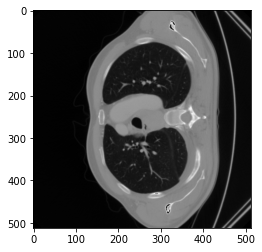

In [40]:
plt.imshow(layer, cmap="gray")

In [41]:
#create block of BlockSize from ONE slice !!!---> blocks
def createBlocks(layer, zCoord, blockSize, print_Coord=True):
    blocks = []

    for i in range(int(512/blockSize)):
        for j in range(int(512/blockSize)):
            blocks.append(layer[i*blockSize : blockSize*(i+1), j*blockSize : blockSize*(j+1)])
            if (print_Coord):
                print(str(len(blocks)) + " : x=" + str(blockSize*(2*i+1)/2) + " y=" + str(blockSize*(2*j+1)/2) + " z=" + str(zCoord))

    return blocks

In [42]:
patches = np.array(createBlocks(layer, z, blockSize=BLOCK_SIZE))
patches_predictable = np.expand_dims(patches, axis=3)

1 : x=31.5 y=31.5 z=350
2 : x=31.5 y=94.5 z=350
3 : x=31.5 y=157.5 z=350
4 : x=31.5 y=220.5 z=350
5 : x=31.5 y=283.5 z=350
6 : x=31.5 y=346.5 z=350
7 : x=31.5 y=409.5 z=350
8 : x=31.5 y=472.5 z=350
9 : x=94.5 y=31.5 z=350
10 : x=94.5 y=94.5 z=350
11 : x=94.5 y=157.5 z=350
12 : x=94.5 y=220.5 z=350
13 : x=94.5 y=283.5 z=350
14 : x=94.5 y=346.5 z=350
15 : x=94.5 y=409.5 z=350
16 : x=94.5 y=472.5 z=350
17 : x=157.5 y=31.5 z=350
18 : x=157.5 y=94.5 z=350
19 : x=157.5 y=157.5 z=350
20 : x=157.5 y=220.5 z=350
21 : x=157.5 y=283.5 z=350
22 : x=157.5 y=346.5 z=350
23 : x=157.5 y=409.5 z=350
24 : x=157.5 y=472.5 z=350
25 : x=220.5 y=31.5 z=350
26 : x=220.5 y=94.5 z=350
27 : x=220.5 y=157.5 z=350
28 : x=220.5 y=220.5 z=350
29 : x=220.5 y=283.5 z=350
30 : x=220.5 y=346.5 z=350
31 : x=220.5 y=409.5 z=350
32 : x=220.5 y=472.5 z=350
33 : x=283.5 y=31.5 z=350
34 : x=283.5 y=94.5 z=350
35 : x=283.5 y=157.5 z=350
36 : x=283.5 y=220.5 z=350
37 : x=283.5 y=283.5 z=350
38 : x=283.5 y=346.5 z=350
39 : x=28

In [43]:
#show image
def show_slices(slices, blockSize):
        fig=plt.figure(figsize=(blockSize, blockSize))
        columns = int(512/blockSize)
        rows = int(512/blockSize)
        
        ax = []
        for i in range(len(slices)):
                ax.append( fig.add_subplot(rows, columns, i+1) )
                ax[-1].set_xticklabels([])
                ax[-1].set_title("ax:"+str(i), fontsize=50)  # set title
                plt.imshow(slices[i], cmap="gray", vmin=0, vmax=255)

        plt.show()

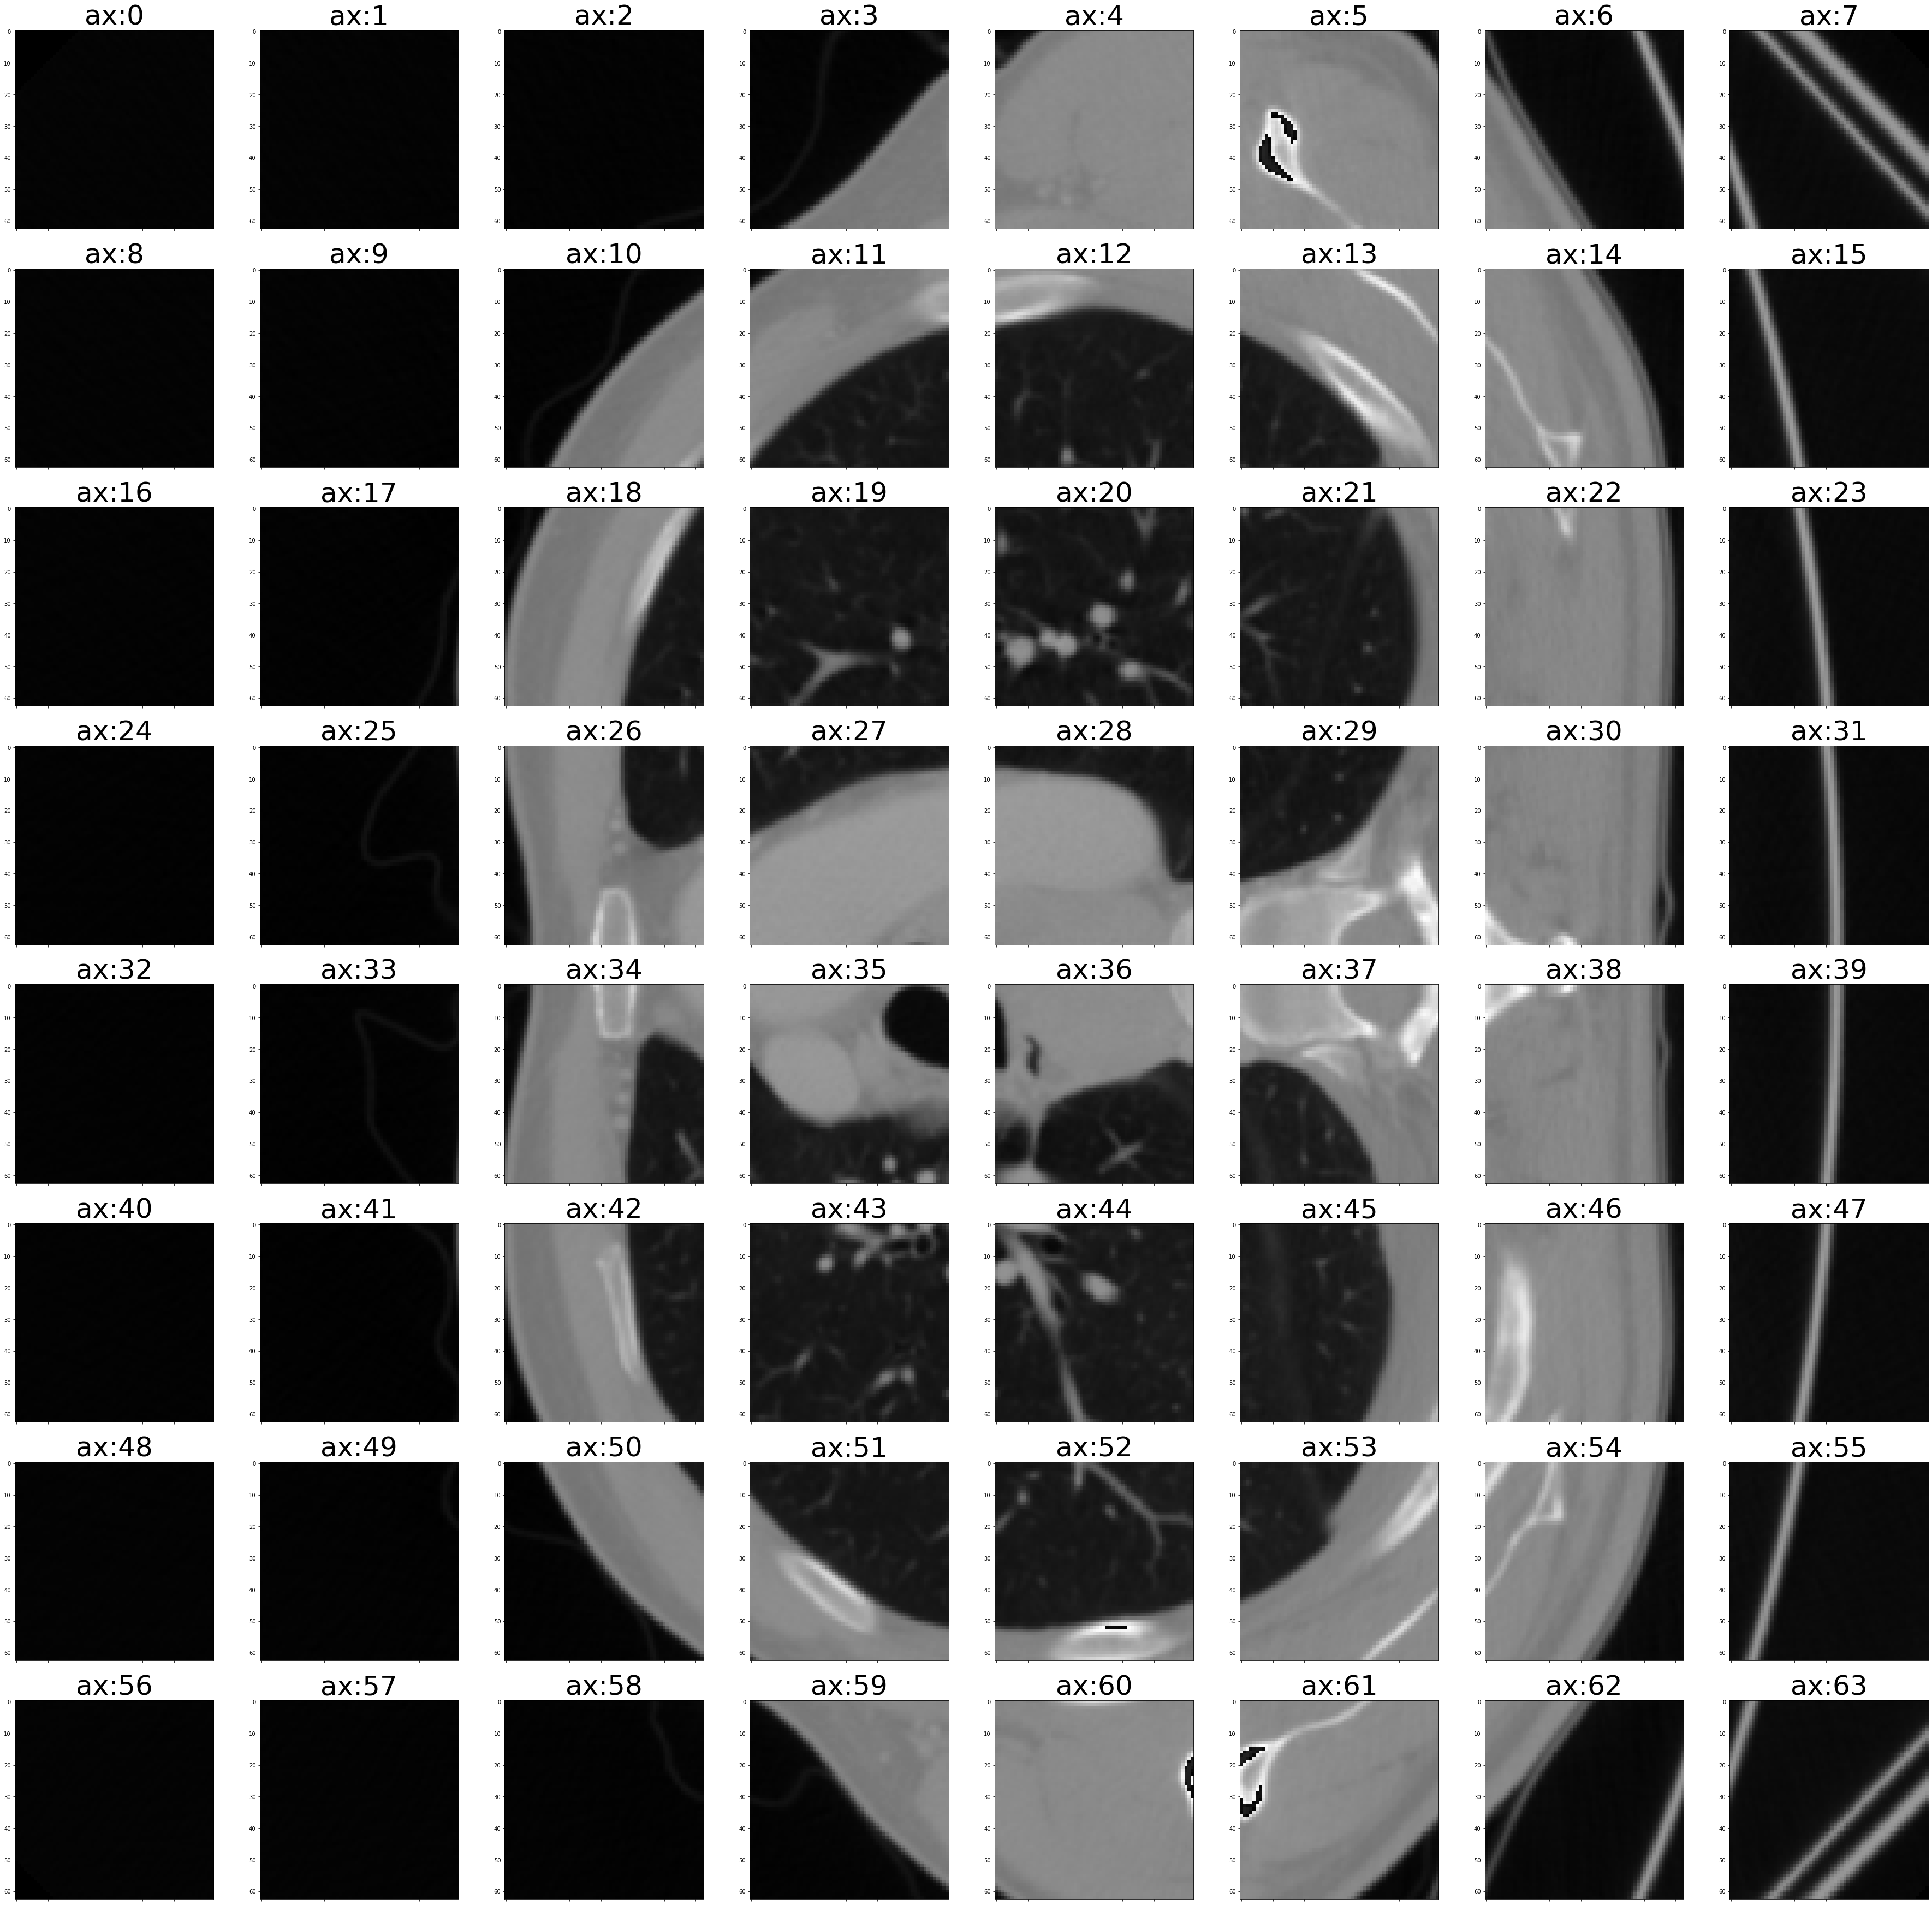

In [44]:
show_slices(patches, BLOCK_SIZE)

In [45]:
labels = ['adrenal_gland_left',
'adrenal_gland_rigth',
'aorta',
'background',
'body_envelope',
'first_lumbar_vertebra',
'gallbladder',
'kidney_left',
'kidney_right',
'liver',
'lung_left',
'lung_right',
'muscle_body_of_left_rectus_abdominis',
'muscle_body_of_right_rectus_abdominis',
'pancreas',
'psoas_major_left',
'psoas_major_right',
'spleen',
'sternum',
'thorax-abdomen',
'thyroid_gland',
'trachea',
'urinary_bladder']

In [46]:
# Check model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 31, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 800)               6554400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [62]:
classes = model.predict(patches_predictable)
classes.shape

(64, 23)

Text(0.5, 1.0, 'predicted : lung_left')

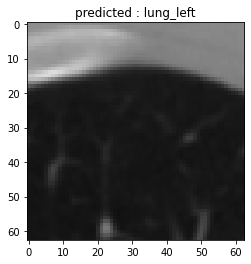

In [63]:
index = 12
plt.imshow(np.squeeze(patches[index]), cmap="gray", vmin=0, vmax=255)
plt.title('predicted : ' + labels[np.argmax(classes[index])])

In [64]:
def plotImgOverLayer(layer, prob):
        fig = plt.figure(frameon=False)
        background = plt.imshow(layer, cmap="gray")
        foreground = plt.imshow(prob, alpha=.5)

In [139]:
def getPredByLabel(predictions, label):
    labelTab = []

    #loop over the different blocks
    for k in range(len(predictions)):

        # get index of highest class prob
        highest = np.argmax(predictions[k])

        if (labels[highest] == label):
            #get prob value
            prob_highest = predictions[k][highest]
            print('block : ' + str(k) + ' is predicted with ' + str(prob_highest) + ' as a ' + label)
            labelTab.append(prob_highest)
        else:
            labelTab.append(0)

    return labelTab

In [140]:
#interpolate 2D grid of proba of Label to original image size 512x512
def interpolateTab(tab, blockSize):
        vals = np.reshape(tab, (len(tab)*len(tab[0])))
        pts = np.array([[i,j] for i in np.linspace(0,1,int(512/blockSize)) for j in np.linspace(0,1,int(512/blockSize))] )
        grid_x, grid_y = np.mgrid[0:1:512j, 0:1:512j]
        grid_z = inter.griddata(pts, vals, (grid_x, grid_y), method='linear')
        return grid_z

In [144]:
def showPredLabelSlice(image_data, zCoord, model, label, block_size=33):

        # get layer from imag_data
        layer = np.array(image_data[:,:, zCoord])

        # create 2D patches
        blocks = np.array(createBlocks(layer, zCoord, blockSize=BLOCK_SIZE, print_Coord=False))

        # add extra dim to get shape : (BLOCK_SIZE , BLOCK_SIZE, 1)
        patches_predictable = np.expand_dims(blocks, axis=3)
 
        # predict probabilities for each block to be one of the 23 organs
        predictions = model.predict(patches_predictable)

        # get array with prob values where block is recognized as a "label"
        pred_label = getPredByLabel(predictions, label)

        # reshape 1D array to 2D to respect shape of layer
        pred_label = np.reshape(pred_label, (-1, int(512/block_size)))

        # interpoate 2D array to get an orinal shaped image
        pred_label = interpolateTab(pred_label, block_size)

        return layer, pred_label


In [145]:
layer , pred_label = showPredLabelSlice(image_data,360, model, 'trachea', BLOCK_SIZE)

block : 35 is predicted with 0.9999999 as a trachea


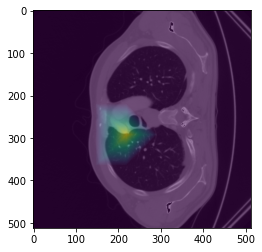

In [147]:
plotImgOverLayer(layer, pred_label)